# Armageddon: solver

## `solver` module
* Solve the system of differential equations describing meteoroid entry
* Calculate the kinetic energy lost per unit altitude
* Compute the burst altitude, burst energy and horizontal path length from the entry point

In [16]:
# import basic requirements
import numpy as np
import matplotlib.pyplot as plt

### Importing `Planet()` class

The class `Planet()` contains functions to solve the system of ordinary differential equations and analyse the outcomes. It consists of three main functions:
* `solve_atmospheric_entry` for intial calculation for the ODE system
* `calculate_energy` for computing the kinetic energy loss
* `analyse_outcome` for computing the burst parameters

The `__init__` function sets up initial parameters and constants for the target planet, which is Earth in our case.

In [17]:
# import the class within the module and intialise
from armageddon.solver import Planet
earth = Planet()

The next function `solve_atmospheric_entry` is where we solve the system to generate an initial DataFrame with meteroid parameters.

One can choose a method to solve the ODE system as an input for `solve_atmospheric_entry`:
 * 4th-Order Runge Kutta
 * Foward-Euler
 
The function will take a string argument as an input to decide which solving method to use. If none assigned, it will take 'RK4' by default. Below are the implemented methods.

In [19]:
# 'RK4' selected as the solver

def solve_atmospheric_entry_RK4(self, radius, 
                            velocity, angle, init_altitude, dt):

        self.velocity = [velocity]
        self.mass = [4/3 * np.pi * radius**3 * self.density]
        self.angle = [angle]
        self.altitude = [init_altitude]
        self.distance = [0]
        self.radius = [radius]
        timestep = dt
        self.alltimestep = [0]
        while True:
            ctheta, cr, cz, cv, cm, cx = self.RK4_helper(dt)
            self.velocity.append(cv + self.velocity[-1])
            self.mass.append(cm + self.mass[-1])
            self.altitude.append(cz + self.altitude[-1])
            self.angle.append(ctheta + self.angle[-1])
            self.distance.append(cx + self.distance[-1])
            self.radius.append(cr + self.radius[-1])
            self.alltimestep.append(timestep + self.alltimestep[-1])
            if self.altitude[-1] <= 0 or self.mass[-1] <= 0:
                break

def RK4_helper(self, timestep):
    variables = np.array([self.angle[-1], self.radius[-1],
                          self.altitude[-1], self.velocity[-1],
                          self.mass[-1], self.distance[-1]])
    k1 = self.calculator_rk4(variables)
    k2 = self.calculator_rk4(variables + 0.5 * timestep * k1)
    k3 = self.calculator_rk4(variables + 0.5 * timestep * k2)
    k4 = self.calculator_rk4(variables + timestep * k3)
    change = (k1 + 2 * k2 + 2 * k3 + k4) * timestep / 6
    return change

def calculator_rk4(self, variables):
    angle, radius, altitude, velocity, mass, _ = variables
    cos_theta = np.cos(angle)
    sin_theta = np.sin(angle)
    area = np.pi * radius**2
    rhoa = self.rhoa(altitude)
    rhoAv = rhoa * area * velocity
    dvdt = -self.Cd * rhoAv * velocity / (2 * mass) + self.g * sin_theta
    dmdt = -self.Ch * rhoAv * velocity**2 / (2 * self.Q)
    dthetadt = (-self.Cl * rhoAv / (2 * mass)
                + self.g * cos_theta / velocity
                - velocity * cos_theta / (self.Rp + altitude))
    dzdt = -velocity * sin_theta
    dxdt = velocity * cos_theta / (1 + altitude / self.Rp)
    ram = self.rhoa(altitude) * velocity**2
    drdt = 0
    if ram > self.strength:
        if self.burstpoint == -1:
            self.burstpoint = len(self.distance)
        drdt = (7 * rhoa * self.alpha/2/self.density)**0.5 * velocity
    result = np.array([dthetadt, drdt, dzdt, dvdt, dmdt, dxdt])
    return result

In [23]:
# 'FE' selected as the solver

def solve_atmospheric_entry_FE(
            self, radius, velocity, angle,
            init_altitude, dt):
    self.velocity = [velocity]
    self.mass = [4/3 * np.pi * radius**3 * self.density]
    self.angle = [angle]
    self.altitude = [init_altitude]
    self.distance = [0]
    self.radius = [radius]
    timestep = dt
    self.alltimestep = [0]
    while True:
        cos_theta = np.cos(self.angle[-1])
        sin_theta = np.sin(self.angle[-1])
        area = np.pi * self.radius[-1]**2
        rhoa = self.rhoa(self.altitude[-1])
        rhoAv = rhoa * area * self.velocity[-1]
        dvdt = (-self.Cd * rhoAv * self.velocity[-1] / (2 * self.mass[-1])
                 + self.g * sin_theta)
        dmdt = -self.Ch * rhoAv * self.velocity[-1]**2 / (2 * self.Q)
        dthetadt = (-self.Cl * rhoAv / (2 * self.mass[-1])
                    + self.g * cos_theta / self.velocity[-1]
                    - self.velocity[-1] * cos_theta
                    / (self.Rp + self.altitude[-1]))
        dzdt = -self.velocity[-1] * sin_theta
        dxdt = (self.velocity[-1] * cos_theta
                / (1 + self.altitude[-1] / self.Rp))
        ram = self.rhoa(self.altitude[-1]) * self.velocity[-1]**2
        drdt = 0
        if ram > self.strength:
            if self.burstpoint == -1:
                self.burstpoint = len(self.distance)
            drdt = ((7 * rhoa * self.alpha/2/self.density)**0.5
                    * self.velocity[-1])
        self.velocity.append(dvdt * timestep + self.velocity[-1])
        self.mass.append(dmdt * timestep + self.mass[-1])
        self.altitude.append(dzdt * timestep + self.altitude[-1])
        self.angle.append(dthetadt * timestep + self.angle[-1])
        self.distance.append(dxdt * timestep + self.distance[-1])
        self.radius.append(drdt * timestep + self.radius[-1])
        self.alltimestep.append(timestep + self.alltimestep[-1])
        if self.altitude[-1] <= 0 or self.mass[-1] <= 0:
            break


Using the selected solver, the function will save the solution of the ODE system in a DataFrame with features of the asteroid.

In [24]:
result1 = earth.solve_atmospheric_entry(radius=35, angle=45,
                                       strength=1e7, density=3000,
                                       velocity=19e3)
result1

,velocity,mass,angle,altitude,distance,radius,time
0,19000.000000,5.387831e+08,45.000000,100000.000000,0.000000,35.000000,0.00
1,19000.346548,5.387831e+08,44.995098,99328.248558,661.370490,35.000000,0.05
2,19000.693040,5.387831e+08,44.990195,98656.542339,1322.878295,35.000000,0.10
3,19001.039476,5.387830e+08,44.985291,97984.881365,1984.523449,35.000000,0.15
4,19001.385852,5.387830e+08,44.980385,97313.265659,2646.305984,35.000000,0.20
...,...,...,...,...,...,...,...
1238,77.534373,7.393132e+07,89.714825,18.270871,96803.453944,258.277621,61.90
1239,77.514817,7.393129e+07,89.716252,14.394201,96803.473240,258.277621,61.95
1240,77.495270,7.393126e+07,89.717670,10.518507,96803.492434,258.277621,62.00
1241,77.475734,7.393123e+07,89.719080,6.643791,96803.511527,258.277621,62.05


One could visualise the evolution of the asteroid in the atmosphere by plotting some graphs of the asteroid parameters against altitude or time.

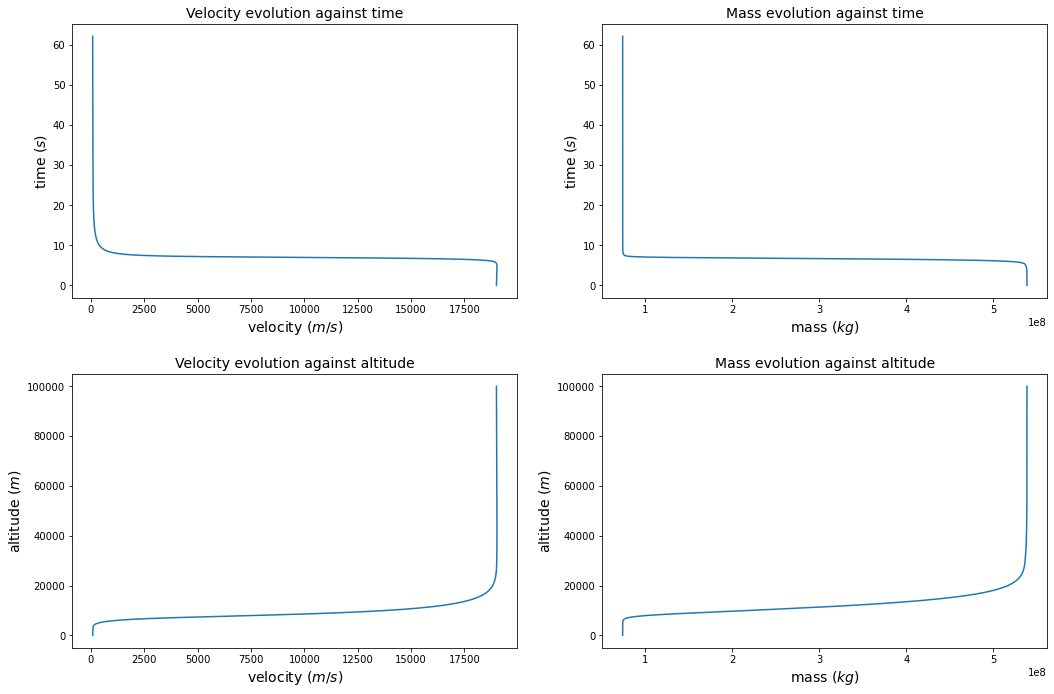

In [59]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(result1['velocity'], result1['time'])
ax1.set_ylabel('time $(s)$', fontsize=14)
ax1.set_xlabel('velocity $(m/s)$', fontsize=14)
ax1.set_title('Velocity evolution against time', fontsize=14)

ax2.plot(result1['mass'], result1['time'])
ax2.set_ylabel('time $(s)$', fontsize=14)
ax2.set_xlabel('mass $(kg)$', fontsize=14)
ax2.set_title('Mass evolution against time', fontsize=14)

ax3.plot(result1['velocity'], result1['altitude'])
ax3.set_ylabel('altitude $(m)$', fontsize=14)
ax3.set_xlabel('velocity $(m/s)$', fontsize=14)
ax3.set_title('Velocity evolution against altitude', fontsize=14)

ax4.plot(result1['mass'], result1['altitude'])
ax4.set_ylabel('altitude $(m)$', fontsize=14)
ax4.set_xlabel('mass $(kg)$', fontsize=14)
ax4.set_title('Mass evolution against altitude', fontsize=14)

plt.tight_layout(pad = 2.0)

The next function `calculate_energy` takes the results from `solve_atmospheric_entry` to calculate the kinetic energy loss per unit altitude in kilotons TNT per km. The function returns the same DataFrame as from `solve_atmospheric_entry`, but with an extra column 'dedz' added, where the kinetic energy loss is stored.

In [21]:
result2 = earth.calculate_energy(result1)
result2

,velocity,mass,angle,altitude,distance,radius,time,dedz
0,19000.000000,5.387831e+08,45.000000,100000.000000,0.000000,35.000000,0.00,-0.000000
1,19000.346548,5.387831e+08,44.995098,99328.248558,661.370490,35.000000,0.05,-1.260322
2,19000.693040,5.387831e+08,44.990195,98656.542339,1322.878295,35.000000,0.10,-1.260064
3,19001.039476,5.387830e+08,44.985291,97984.881365,1984.523449,35.000000,0.15,-1.259782
4,19001.385852,5.387830e+08,44.980385,97313.265659,2646.305984,35.000000,0.20,-1.259477
...,...,...,...,...,...,...,...,...
1238,77.534373,7.393132e+07,89.714825,18.270871,96803.453944,258.277621,61.90,0.006919
1239,77.514817,7.393129e+07,89.716252,14.394201,96803.473240,258.277621,61.95,0.006916
1240,77.495270,7.393126e+07,89.717670,10.518507,96803.492434,258.277621,62.00,0.006912
1241,77.475734,7.393123e+07,89.719080,6.643791,96803.511527,258.277621,62.05,0.006909


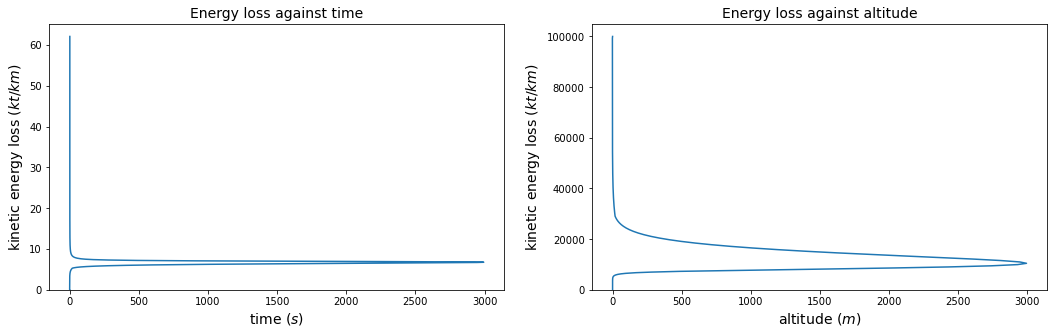

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(result2['dedz'], result2['time'])
ax1.set_ylim(ymin=0)
ax1.set_xlabel('time $(s)$', fontsize=14)
ax1.set_ylabel('kinetic energy loss $(kt/km)$', fontsize=14)
ax1.set_title('Energy loss against time', fontsize=14)

ax2.plot(result2['dedz'], result2['altitude'])
ax2.set_ylim(ymin=0)
ax2.set_xlabel('altitude $(m)$', fontsize=14)
ax2.set_ylabel('kinetic energy loss $(kt/km)$', fontsize=14)
ax2.set_title('Energy loss against altitude', fontsize=14)

plt.tight_layout(pad = 2.0)

The next function `analyse_outcome` is where we solve the system to generate an initial DataFrame.

In [22]:
outcome = earth.analyse_outcome(result2)
outcome

{'outcome': 'Airburst',
 'burst_peak_dedz': 2994.1523510101592,
 'burst_altitude': 10459.247706169299,
 'burst_distance': 89798.00494327919,
 'burst_energy': 16894.541385001165}

Each dictionary gives the detail of the impact event.